# Import

In [1]:
import os, sys

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import dproc, sgml, sgnn, sgutil, sgpp

print(sys.version)

for i in [pd, pl, np, mpl, sns, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

2025-01-07 08:59:00.627596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736240340.639363   70533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736240340.642951   70533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 08:59:00.654953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
catboost 1.2.5
xgboost 2.1.2


In [2]:
for i in ['data', 'result', 'model', 'img']:
    if not os.path.exists(i):
        os.mkdir(i)

data_path = 'data'
def  get_data_path(name):
    return os.path.join(data_path, name)

if not os.path.exists(get_data_path('train.csv')):
    !kaggle competitions download -c playground-series-s4e8
    !unzip playground-series-s4e8.zip -d data

sc = sgutil.SGCache('img', 'result')

In [3]:
from io import StringIO
df_var_info = pd.read_csv(
    StringIO("""name	role	type	description
    poisonous	Target	Categorical	
    cap-shape	Feature	Categorical	bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
    cap-surface	Feature	Categorical	fibrous=f,grooves=g,scaly=y,smooth=s
    cap-color	Feature	Binary	brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
    bruises	Feature	Categorical	bruises=t,no=f
    odor	Feature	Categorical	almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
    gill-attachment	Feature	Categorical	attached=a,descending=d,free=f,notched=n
    gill-spacing	Feature	Categorical	close=c,crowded=w,distant=d
    gill-size	Feature	Categorical	broad=b,narrow=n
    gill-color	Feature	Categorical	black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    stalk-shape	Feature	Categorical	enlarging=e,tapering=t
    stalk-root	Feature	Categorical	bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    stalk-surface-above-ring	Feature	Categorical	fibrous=f,scaly=y,silky=k,smooth=s
    stalk-surface-below-ring	Feature	Categorical	fibrous=f,scaly=y,silky=k,smooth=s
    stalk-color-above-ring	Feature	Categorical	brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    stalk-color-below-ring	Feature	Categorical	brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    veil-type	Feature	Binary	partial=p,universal=u
    veil-color	Feature	Categorical	brown=n,orange=o,white=w,yellow=y
    ring-number	Feature	Categorical	none=n,one=o,two=t
    ring-type	Feature	Categorical	cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
    spore-print-color	Feature	Categorical	black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
    population	Feature	Categorical	abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
    habitat	Feature	Categorical	grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d"""),
    sep = '\t'
).assign(
    name = lambda x: x['name'].str.strip()
)
df_var_info.set_index('name', inplace=True)

In [4]:
if not os.path.exists(get_data_path('train.parquet')):
    df_type = dproc.merge_type_df(
        [pl.scan_csv(get_data_path(i)).pipe(dproc.get_type_df) for i in ['train.csv', 'test.csv']]
    )
    pl_type = dproc.get_type_pl(df_type)
    pl.scan_csv(get_data_path('train.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('train.parquet')
    )
    pl.scan_csv(get_data_path('test.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('test.parquet')
    )
    df_type['dtype'] = df_type.index.to_series().map(pd.Series(pl_type).astype(str))
    df_type.join(df_var_info, how = 'left').assign(
        description = lambda x: x['description'].fillna("Kaggle created")
    ).to_csv(get_data_path('var.csv'))
df_var = pd.read_csv(get_data_path('var.csv'), index_col = 'feature')

In [5]:
target = 'class'
df_train = pd.read_parquet(get_data_path('train.parquet')).set_index('id')
df_test = pd.read_parquet(get_data_path('test.parquet')).set_index('id')
df_var.drop(index = ['id', target], inplace=True)

In [6]:
X_cat = df_var.query('dtype == "Categorical"').index.tolist()
X_num = df_var.loc[df_var['dtype'].str.startswith('Float')].index.tolist()
len(X_cat) + len(X_num), df_train.shape, df_test.shape

(20, (3116945, 21), (2077964, 20))

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# Target

In [10]:
pd.concat([
    df_train[target].value_counts().rename('count'),
    df_train[target].value_counts(normalize=True).rename('ratio')
], axis = 1)

,count,ratio
class,,
p,1705396,0.547137
e,1411549,0.452863


# Categorical Variables

모두 명목형 변수로 보이고, 모든 변수가 노이즈를 포함하고 있으며, 노이즈 변수는 빈도수가 낮은 변수들로 보입니다.

이를 정리해주는 청소 작업이 필요합니다.

## Cleaning data

In [11]:
ct_cat = ColumnTransformer([
    ('caf', sgpp.CatArrangerFreq(min_frequency = 100, unknown_value = 'Unk', na_value = 'Unk'), X_cat)
]).set_output(transform='pandas')
ct_cat.fit(df_train[X_cat])
df_cat = ct_cat.transform(df_train[X_cat])

## Descriptive

In [12]:
from scipy.stats import chi2_contingency
from scipy.spatial.distance import pdist, squareform

In [13]:
sc.cache_result(
    'cat_desc',
    lambda : pd.concat([
        (df_cat == 'Unk').sum().rename('Missing'),
        (df_cat == 'Unk').mean().rename('Missing_ratio'),
        df_cat.nunique().rename('nunique'),
        df_cat.apply(
            lambda x: pd.Series(chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[:2], index = ['chi2, stat', 'chi2, pvalue'])
        ). T
    ], axis = 1), rerun = 0
).sort_values(['chi2, pvalue', 'chi2, stat'], ascending = [True, False])

,Missing,Missing_ratio,nunique,"chi2, stat","chi2, pvalue"
caf__cap-color,12,0.000004,13,208330.755462,0.0
caf__stem-color,38,0.000012,14,206317.990440,0.0
caf__cap-surface,671023,0.215282,12,199240.232405,0.0
caf__gill-attachment,523936,0.168093,8,169648.606124,0.0
caf__stem-surface,1980861,0.635514,9,165450.381251,0.0
caf__gill-color,57,0.000018,13,150819.253763,0.0
caf__ring-type,128880,0.041348,9,127904.172985,0.0
caf__stem-root,2757023,0.884527,6,99319.103129,0.0
caf__habitat,45,0.000014,9,98305.404472,0.0
caf__veil-color,2740947,0.879370,7,92316.923415,0.0


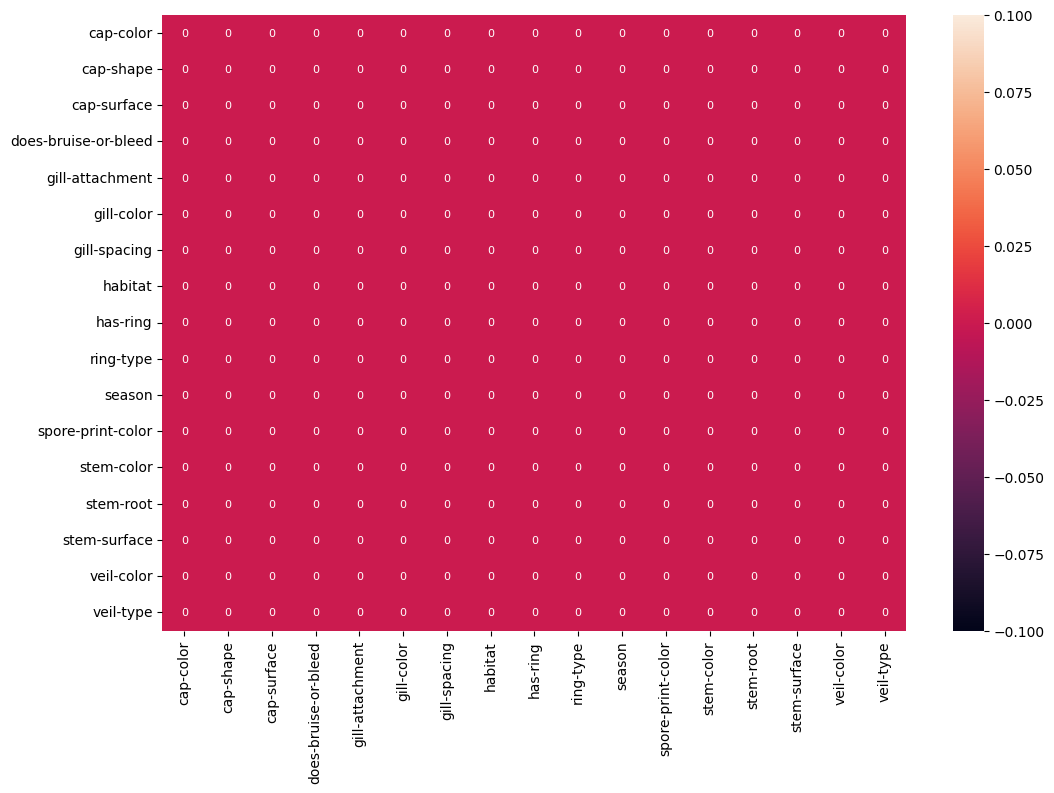

In [14]:
plt.figure(figsize = (12, 8))
sns.heatmap(
    pd.DataFrame(
        squareform(
            sc.cache_result(
                'chi2_cat_var',
                lambda : pdist(df_cat.T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[1]),
                rerun = 0
            )
        ), index = X_cat, columns = X_cat
    ), annot = True, annot_kws = {'size': 8}
)
plt.show()

모든 속성이 연관성이 높습니다.

범주형 변수의 가짓수에 비해 등장하는 종류는 적습니다.

In [15]:
df_cat.nunique().prod()

128184423284736

In [16]:
df_cat.value_counts().size

107637

# Numeric Variables

## Cleaning Data

cap-diameter, stem-height에 약간의 결측치들이 있습니다. 최빈값으로 대체합니다.

In [17]:
from sklearn.impute import SimpleImputer
ct_num = ColumnTransformer([
    ('simp', SimpleImputer(strategy = 'most_frequent'), ['cap-diameter', 'stem-height']),
    ('pt', 'passthrough', ['stem-width'])
]).set_output(transform='pandas')
df_num = ct_num.fit_transform(df_train)

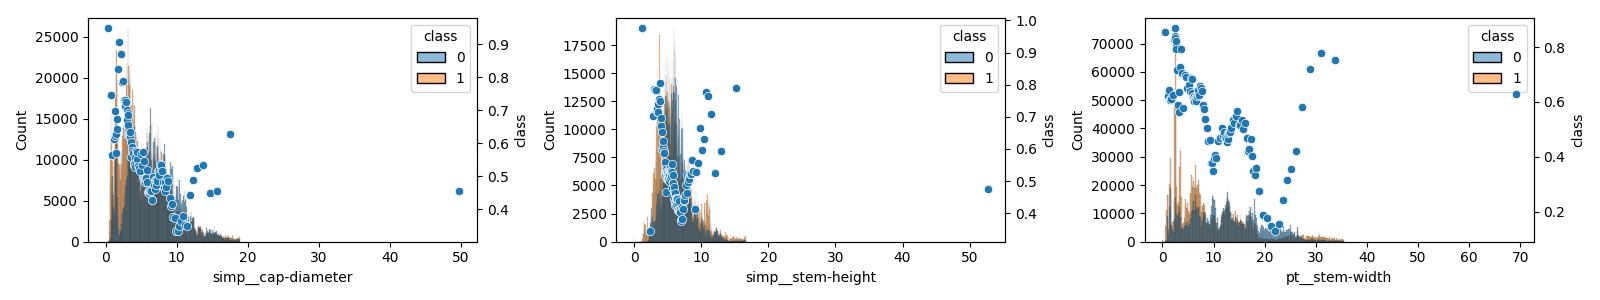

In [18]:
def plot_hist(axes):
    for i, ax in zip(df_num.columns, axes):
        sns.histplot(x = df_num.loc[df_num[i] < df_num[i].quantile(0.99), i], hue = df_train[target], ax=ax)
        df_train.groupby(pd.qcut(df_num[i], q = 100).map(lambda x: (x.left + x.right) / 2), observed=True)[target].mean().pipe(
            lambda x: sns.scatterplot(x, ax = ax.twinx())
        )
sc.cache_fig(
    'hist_num', plot_hist, 1, 3, figsize = (16, 3), redraw = 0
)

In [19]:
df_num.corr()

,simp__cap-diameter,simp__stem-height,pt__stem-width
simp__cap-diameter,1.000000,0.364062,0.746316
simp__stem-height,0.364062,1.000000,0.356225
pt__stem-width,0.746316,0.356225,1.000000


# ML

## Train & Test diff 

In [33]:
import importlib
importlib.reload(sgpp)

<module 'sgpp' from '/home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep8/sgpp.py'>

In [34]:
lbl_enc = LabelEncoder()
lbl_enc.fit(df_train[target])
print(lbl_enc.classes_)
cbt = sgpp.CombineTransformer([
    ('cat', ct_cat),
    ('num', ct_num),
], target, lbl_enc)
df_ml = cbt.transform(df_train)

['e' 'p']


In [39]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([
        df_ml.assign(is_train = True),
        cbt.transform(df_test).assign(is_train = False)
    ], axis = 0).pipe(
        lambda x: cross_val_score(
            lgb.LGBMClassifier(random_state = 123, verbose = -1), x[cbt.get_vars()], x['is_train'], 
            cv = ShuffleSplit(1, train_size = 0.8, random_state = 123), scoring = 'roc_auc', params = {'categorical_feature': cbt.get_vars('cat')}
        )
    ), rerun = 0
)

array([0.50067673])

학습과 평가셋은 구분할 수 없습니다. 테스트셋에만 나타나는 특이 패턴은 없다고 판단 됩니다.

In [23]:
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index, name = 'p'),
    'score_func': lambda df, prds: matthews_corrcoef(df[target].sort_index(), (prds >= 0.5).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target
}

ss = ShuffleSplit(n_splits = 1, train_size = 0.6, random_state = 123)

cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)

## Analysis using CatBoost

In [41]:
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

In [44]:
hparams = {
    'model_params': {'n_estimators': 100, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result = sc.cache_result(
    'feature_imp_iter_cb',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            partial(sgml.gb_shap_learning_result, df=df_ml.sample(frac=0.01, random_state= 123)), 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.9738839021609007], [0.9740120039442951])

In [45]:
confusion_matrix(df_ml.loc[result['valid_prd'].index, target], result['valid_prd'] >= 0.5)

array([[557919,   6796],
       [  9272, 672791]])

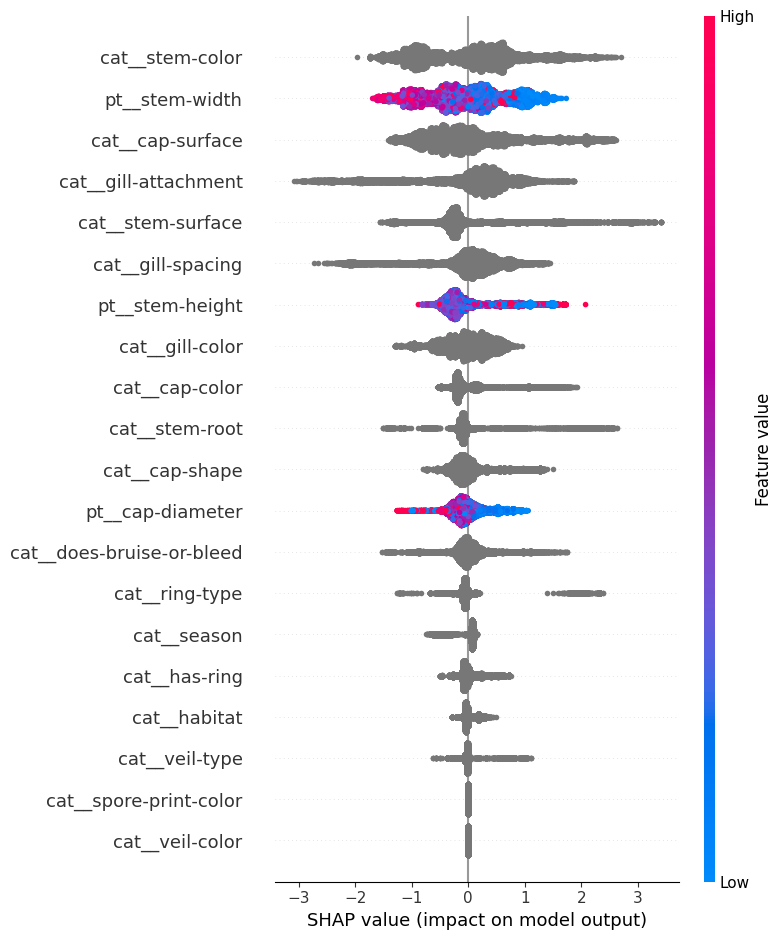

In [46]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

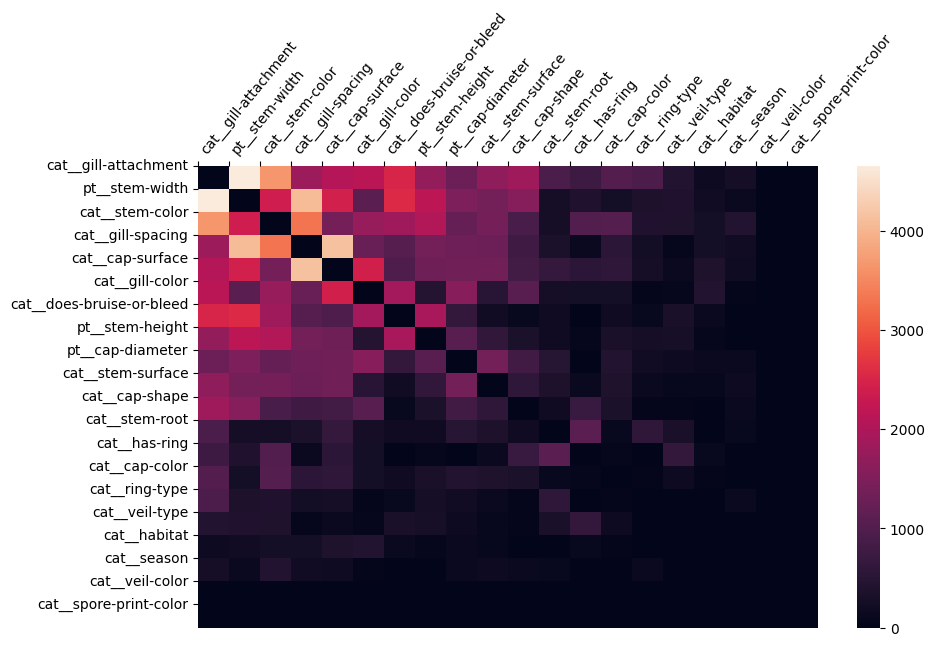

In [47]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [48]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False)

cat__gill-attachment         12.353253
cat__cap-surface             11.826091
pt__stem-width               11.322056
cat__stem-color               9.750478
cat__gill-spacing             9.696561
cat__stem-surface             7.840881
pt__stem-height               5.913634
cat__gill-color               5.670679
pt__cap-diameter              4.611880
cat__does-bruise-or-bleed     4.595490
cat__cap-shape                3.822781
cat__stem-root                3.276797
cat__ring-type                3.081924
cat__cap-color                2.289688
cat__has-ring                 1.569463
cat__veil-type                1.306277
cat__season                   0.590755
cat__habitat                  0.481312
cat__spore-print-color        0.000000
cat__veil-color               0.000000
dtype: float64

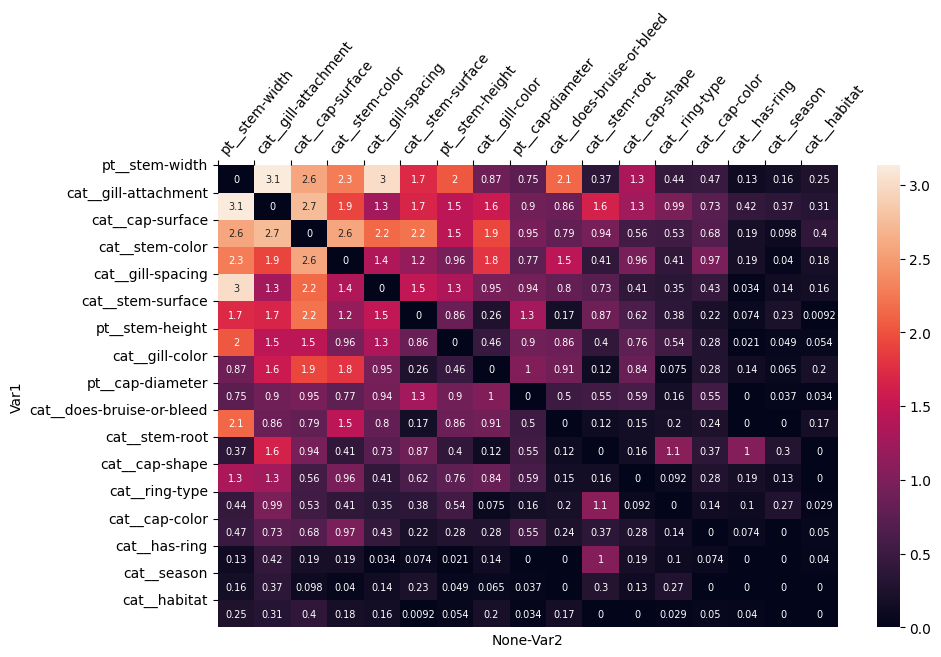

In [49]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [86]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result = sc.cache_result(
    'cb_1',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.9837756634727461], [0.9833530742777087])

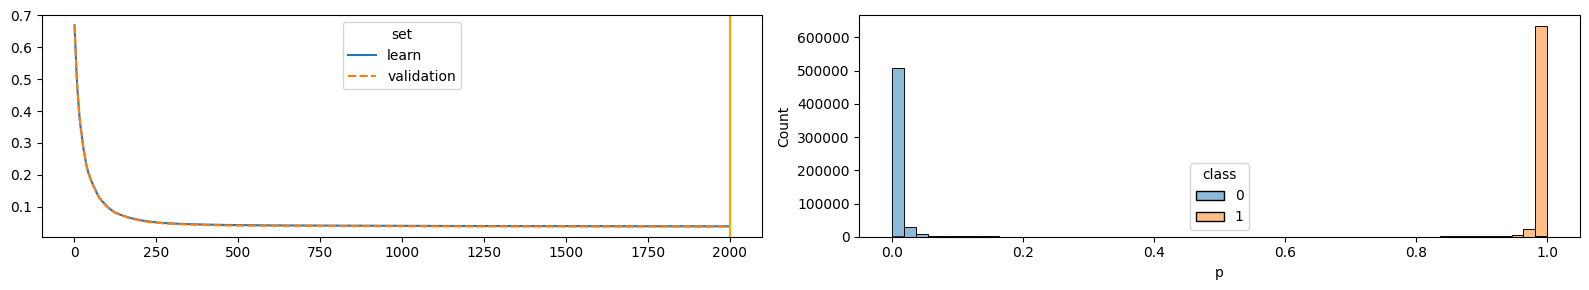

In [107]:
fig, axes= plt.subplots(1, 2, figsize = (16, 3))
sns.lineplot(
    result['model_result'][0]['valid_result'].T.reset_index(level=0, drop=True).T, ax = axes[0]
)
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[0])
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[1], color = 'orange')

sns.histplot(
    x = result['valid_prd'], hue = df_ml.loc[result['valid_prd'].index, target], ax = axes[1]
)
plt.tight_layout()
plt.show()

In [109]:
result['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         11.652438
cat__cap-surface             10.884025
pt__stem-width               10.798786
cat__gill-spacing             9.555153
cat__stem-surface             8.327684
cat__stem-color               8.059510
pt__stem-height               6.349008
cat__gill-color               4.983466
pt__cap-diameter              4.540796
cat__stem-root                4.088228
cat__cap-color                4.062428
cat__does-bruise-or-bleed     4.040670
cat__cap-shape                3.885971
cat__has-ring                 2.342365
cat__ring-type                2.163120
cat__season                   1.943705
cat__habitat                  1.328168
cat__veil-type                0.445387
cat__spore-print-color        0.353377
cat__veil-color               0.195715
dtype: float64

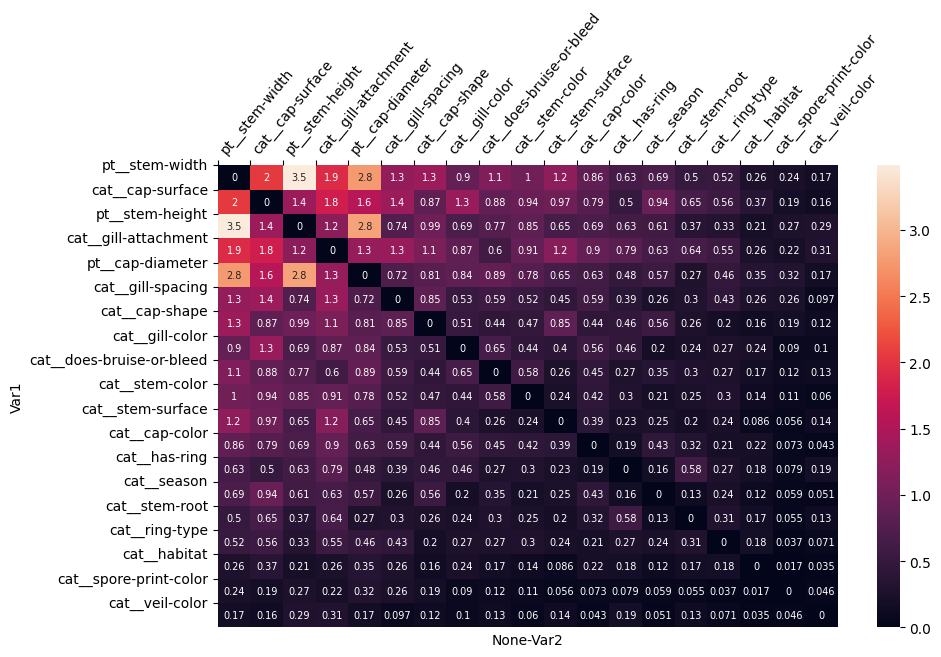

In [105]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [110]:
df_ce = (
    pd.concat([
        -np.log(1 - result['valid_prd']).rename(0),
        -np.log(result['valid_prd']).rename(1), 
    ], axis=1) * pd.get_dummies(df_ml.loc[result['valid_prd'].index, target])
).sum(axis=1).rename('ce').to_frame()

In [116]:
from scipy.stats import kruskal
sc.cache_result(
    'kruskal_cat_cb',
    lambda : pd.concat([pd.Series(kruskal(
        *df_ce.groupby(df_ml.loc[df_ce.index, i], observed = True)['ce'].agg(list)
    ), index = ['stat',  'pvalue'], name = i) for i in cbt.get_vars('cat')
    ], axis=1), rerun = 0
).T.sort_values('stat', ascending = False)

,stat,pvalue
spore-print-color,80974.497824,0.000000e+00
cap-surface,77874.144401,0.000000e+00
habitat,66562.490303,0.000000e+00
gill-color,60446.869856,0.000000e+00
cap-shape,57490.757341,0.000000e+00
stem-surface,55663.663573,0.000000e+00
cap-color,51588.680382,0.000000e+00
has-ring,27496.166867,0.000000e+00
stem-color,26398.607868,0.000000e+00
ring-type,26076.356681,0.000000e+00


In [125]:
from scipy.stats import spearmanr

sc.cache_result(
    'spearman_cat_cb', 
    lambda : df_ml.loc[result['valid_prd'].index, cbt.get_vars('num')].apply(
        lambda x: spearmanr(df_ce['ce'], x)[0]
    ), rerun = 0
)

stem-width      0.176602
cap-diameter    0.150051
stem-height     0.023515
dtype: float64

# Feature Engineering

## Frequency Encdoing (Not Effective)

In [173]:
df_ml_test = cbt.transform(df_test)

In [174]:
freq_enc = FrequencyEncoder()
freq_enc.fit(pd.concat([df_ml[cbt.get_vars('num')], df_ml_test[cbt.get_vars('num')]]))

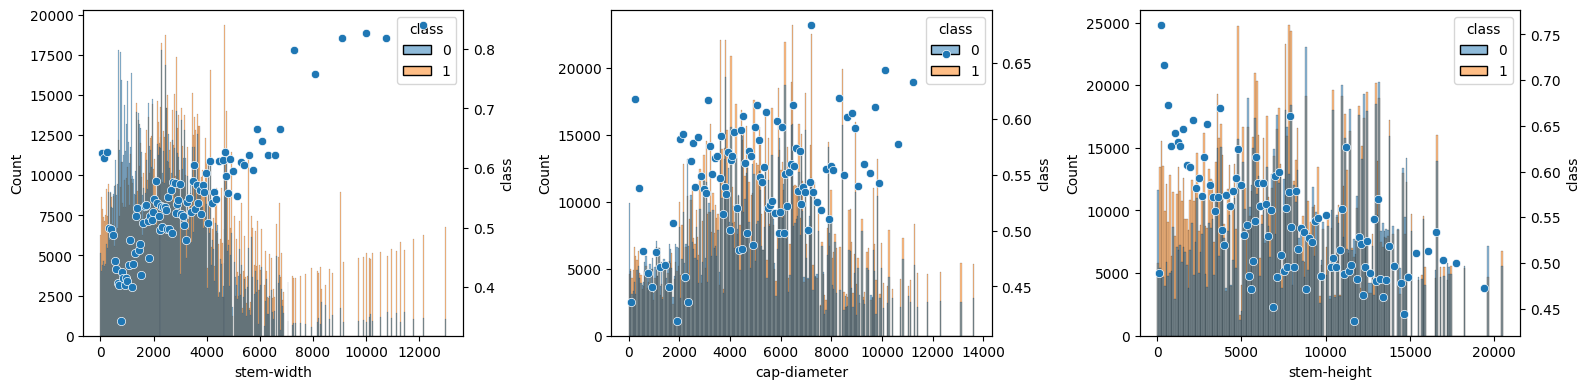

In [175]:
def plot_hist_freq(val, axes):
    df_freq = freq_enc.transform(df_ml[cbt.get_vars('num')])
    for i, ax in zip(val, axes):
        sns.histplot(x = df_freq[i], hue = df_ml[target], ax=ax)
        df_ml.groupby(pd.qcut(df_freq[i], q = 100).map(lambda x: (x.left + x.right) / 2), observed=True)[target].mean().pipe(
            lambda x: sns.scatterplot(x, ax = ax.twinx())
        )
sc.cache_fig(
    'plot_hist_freq_num',
    lambda x: plot_hist_freq(cbt.get_vars('num'), x), 1, 3, figsize = (16, 4), redraw = 1
)

In [183]:
freq_var = [i + '_freq' for i in cbt.get_vars('num')]
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num') + freq_var, 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result = sc.cache_result(
    'cb_freq',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, freq_enc.transform(df_ml[cbt.get_vars('num')]).rename(columns = lambda x: x + '_freq')
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.9837553338112265], [0.9833453004523982])

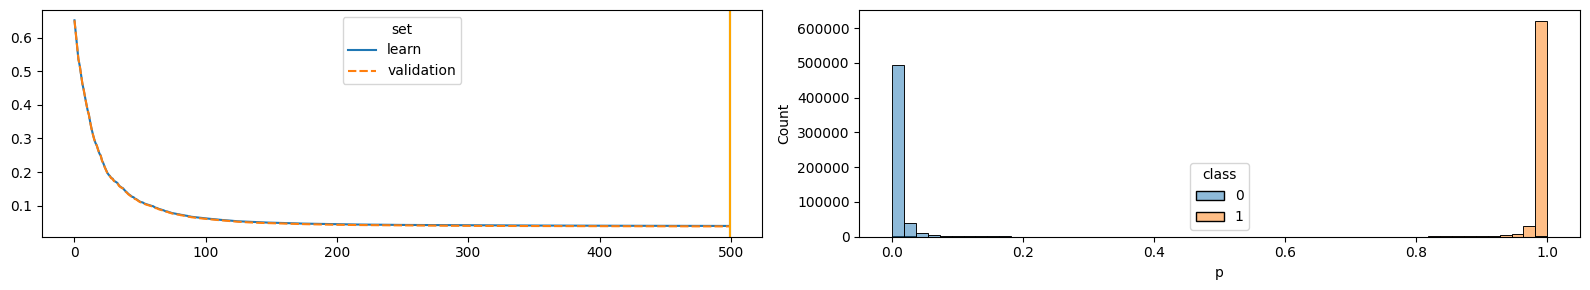

In [180]:
fig, axes= plt.subplots(1, 2, figsize = (16, 3))
sns.lineplot(
    result['model_result'][0]['valid_result'].T.reset_index(level=0, drop=True).T, ax = axes[0]
)
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[0])
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[1], color = 'orange')

sns.histplot(
    x = result['valid_prd'], hue = df_ml.loc[result['valid_prd'].index, target], ax = axes[1]
)
plt.tight_layout()
plt.show()

In [184]:
result['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         11.552056
pt__stem-width               10.719354
cat__cap-surface             10.270542
cat__gill-spacing             9.439527
cat__stem-surface             8.386825
cat__stem-color               8.039964
pt__stem-height               5.719852
cat__gill-color               5.225873
cat__does-bruise-or-bleed     4.616098
cat__stem-root                4.087042
pt__cap-diameter              4.067101
cat__cap-color                3.957945
cat__cap-shape                3.923074
cat__ring-type                2.347094
cat__season                   1.937460
cat__has-ring                 1.862044
cat__habitat                  1.297311
pt__stem-height_freq          1.039856
cat__veil-type                0.473721
pt__stem-width_freq           0.417804
cat__veil-color               0.269430
cat__spore-print-color        0.189104
pt__cap-diameter_freq         0.160923
dtype: float64

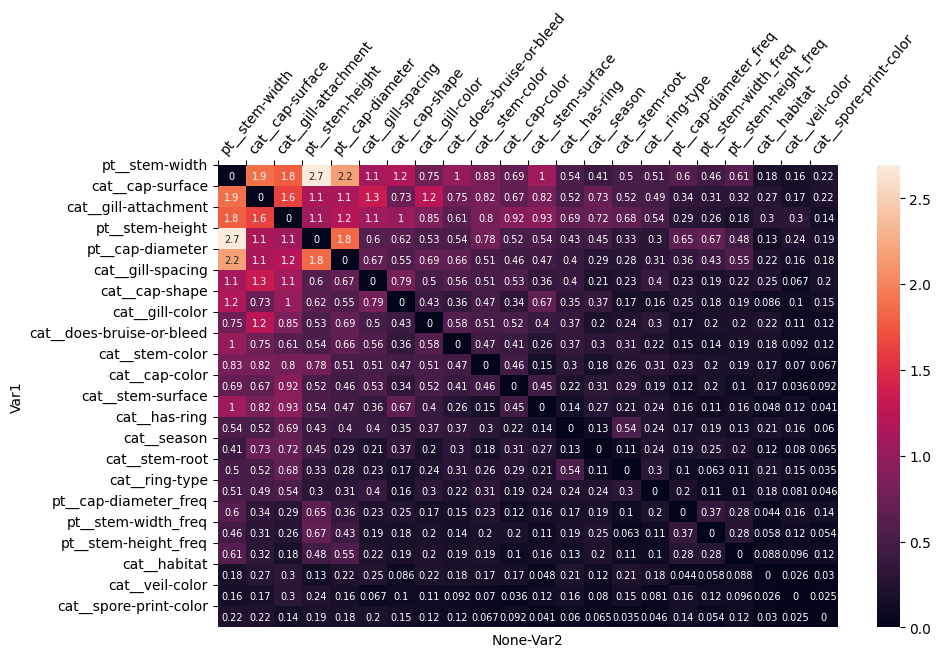

In [185]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()